In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/ISL.zip

In [4]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import utils, callbacks
from tensorflow.keras import utils
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras import layers, models
from keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics

In [5]:
train_folder = '/content/Indian'

all_data = []
for folder in os.listdir(train_folder):
    
    label_folder = os.path.join(train_folder, folder)
    onlyfiles = [{'label':folder,'path':os.path.join(label_folder, f)} for f in os.listdir(label_folder) if os.path.isfile(os.path.join(label_folder, f))]
    #print(onlyfiles)
    all_data += onlyfiles
data_df = pd.DataFrame(all_data)
data_df

,label,path
0,K,/content/Indian/K/526.jpg
1,K,/content/Indian/K/675.jpg
2,K,/content/Indian/K/784.jpg
3,K,/content/Indian/K/234.jpg
4,K,/content/Indian/K/1167.jpg
...,...,...
42740,F,/content/Indian/F/702.jpg
42741,F,/content/Indian/F/979.jpg
42742,F,/content/Indian/F/38.jpg
42743,F,/content/Indian/F/510.jpg


In [6]:
x_train,x_holdout = train_test_split(data_df, test_size= 0.10, random_state=42,stratify=data_df[['label']])
x_train,x_test = train_test_split(x_train, test_size= 0.20, random_state=42,stratify=x_train[['label']])

In [7]:
img_width, img_height = 64, 64
batch_size = 128
y_col = 'label'
x_col = 'path'
no_of_classes = len(data_df[y_col].unique())


train_datagen = ImageDataGenerator(rescale = 1/255.0)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=x_train,x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height),class_mode='categorical', batch_size=batch_size,
    shuffle=False,
)

validation_datagen = ImageDataGenerator(rescale = 1/255.0)
validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=x_test, x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height), class_mode='categorical', batch_size=batch_size,
    shuffle=False
)

holdout_datagen = ImageDataGenerator(rescale = 1/255.0)
holdout_generator = holdout_datagen.flow_from_dataframe(
    dataframe=x_holdout, x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height), class_mode='categorical', batch_size=batch_size,
    shuffle=False
)

Found 30776 validated image filenames belonging to 35 classes.
Found 7694 validated image filenames belonging to 35 classes.
Found 4275 validated image filenames belonging to 35 classes.


In [8]:
base_model = ResNet50V2(input_shape=(64, 64, 3), include_top=False, weights="imagenet")
base_model.trainable = False ## Not trainable weights

94668760/94668760 [==============================] - 6s 0us/step


In [9]:
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 34, 34, 64)   0           ['conv1_conv[0][0]']             
                                                                                         

In [10]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(512, activation='relu')
dropout_layer_1 = layers.Dropout(0.5)
prediction_layer = layers.Dense(35, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dropout_layer_1,
    prediction_layer
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 35)                17955     
                                                                 
Total params: 27,777,571
Trainable params: 4,212,771
Non-trainable params: 23,564,800
_________________________________________________________________


In [12]:
classes = 35
epochs = 10
learning_rate = 0.0001

adam = Adam(lr=learning_rate)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator,
                    epochs=epochs,
                    verbose=1,
                    validation_data=validation_generator, shuffle=True)

Epoch 1/10
241/241 [==============================] - 73s 253ms/step - loss: 0.0842 - accuracy: 0.9842 - val_loss: 1.5730e-05 - val_accuracy: 1.0000
Epoch 2/10
241/241 [==============================] - 38s 157ms/step - loss: 0.0092 - accuracy: 0.9978 - val_loss: 1.3184e-06 - val_accuracy: 1.0000
Epoch 3/10
241/241 [==============================] - 39s 161ms/step - loss: 0.0252 - accuracy: 0.9960 - val_loss: 4.4954e-05 - val_accuracy: 1.0000
Epoch 4/10
241/241 [==============================] - 39s 162ms/step - loss: 0.0121 - accuracy: 0.9979 - val_loss: 5.4716e-07 - val_accuracy: 1.0000
Epoch 5/10
241/241 [==============================] - 39s 163ms/step - loss: 0.0160 - accuracy: 0.9976 - val_loss: 1.1518e-06 - val_accuracy: 1.0000
Epoch 6/10
241/241 [==============================] - 40s 166ms/step - loss: 0.0121 - accuracy: 0.9982 - val_loss: 5.1439e-09 - val_accuracy: 1.0000
Epoch 7/10
241/241 [==============================] - 41s 171ms/step - loss: 0.0088 - accuracy: 0.9988 - v

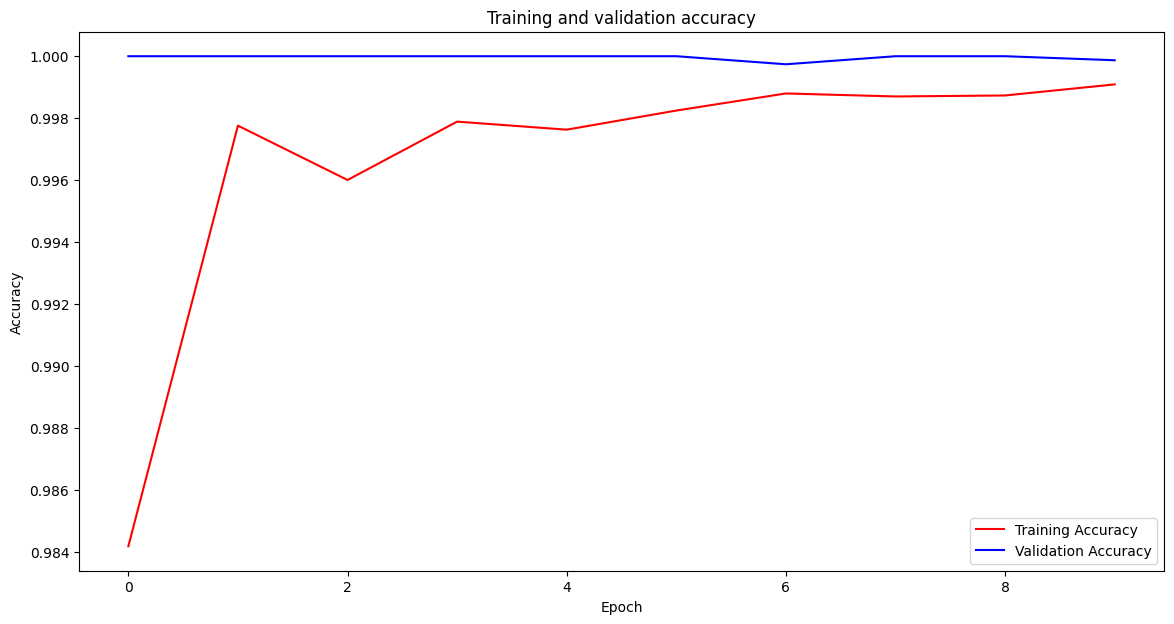

In [13]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

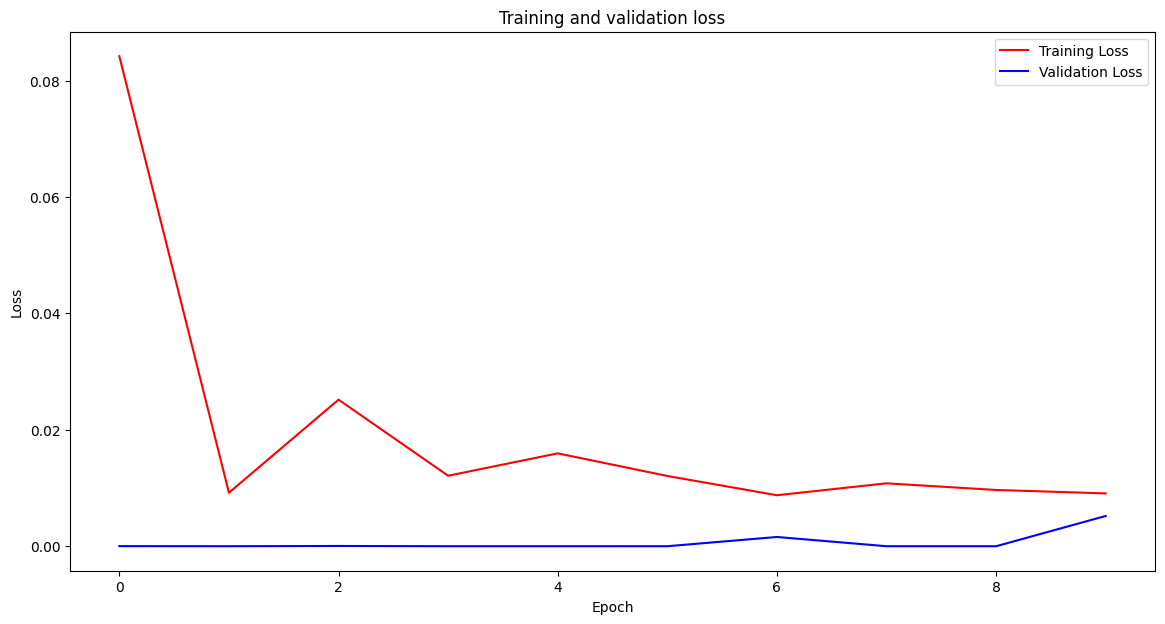

In [14]:
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [15]:
predictions = model.predict(holdout_generator, verbose=1)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1) #multiple categories

true_classes = holdout_generator.classes
class_labels = list(holdout_generator.class_indices.keys())  
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

34/34 [==============================] - 6s 137ms/step
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       120
           2       1.00      1.00      1.00       120
           3       1.00      1.00      1.00       120
           4       1.00      1.00      1.00       120
           5       1.00      1.00      1.00       120
           6       1.00      1.00      1.00       120
           7       1.00      1.00      1.00       120
           8       1.00      1.00      1.00       120
           9       1.00      1.00      1.00       120
           A       1.00      1.00      1.00       120
           B       1.00      1.00      1.00       120
           C       1.00      0.99      0.99       145
           D       1.00      1.00      1.00       120
           E       1.00      1.00      1.00       120
           F       1.00      1.00      1.00       120
           G       1.00      1.00      1.00       120
           H       1.00   

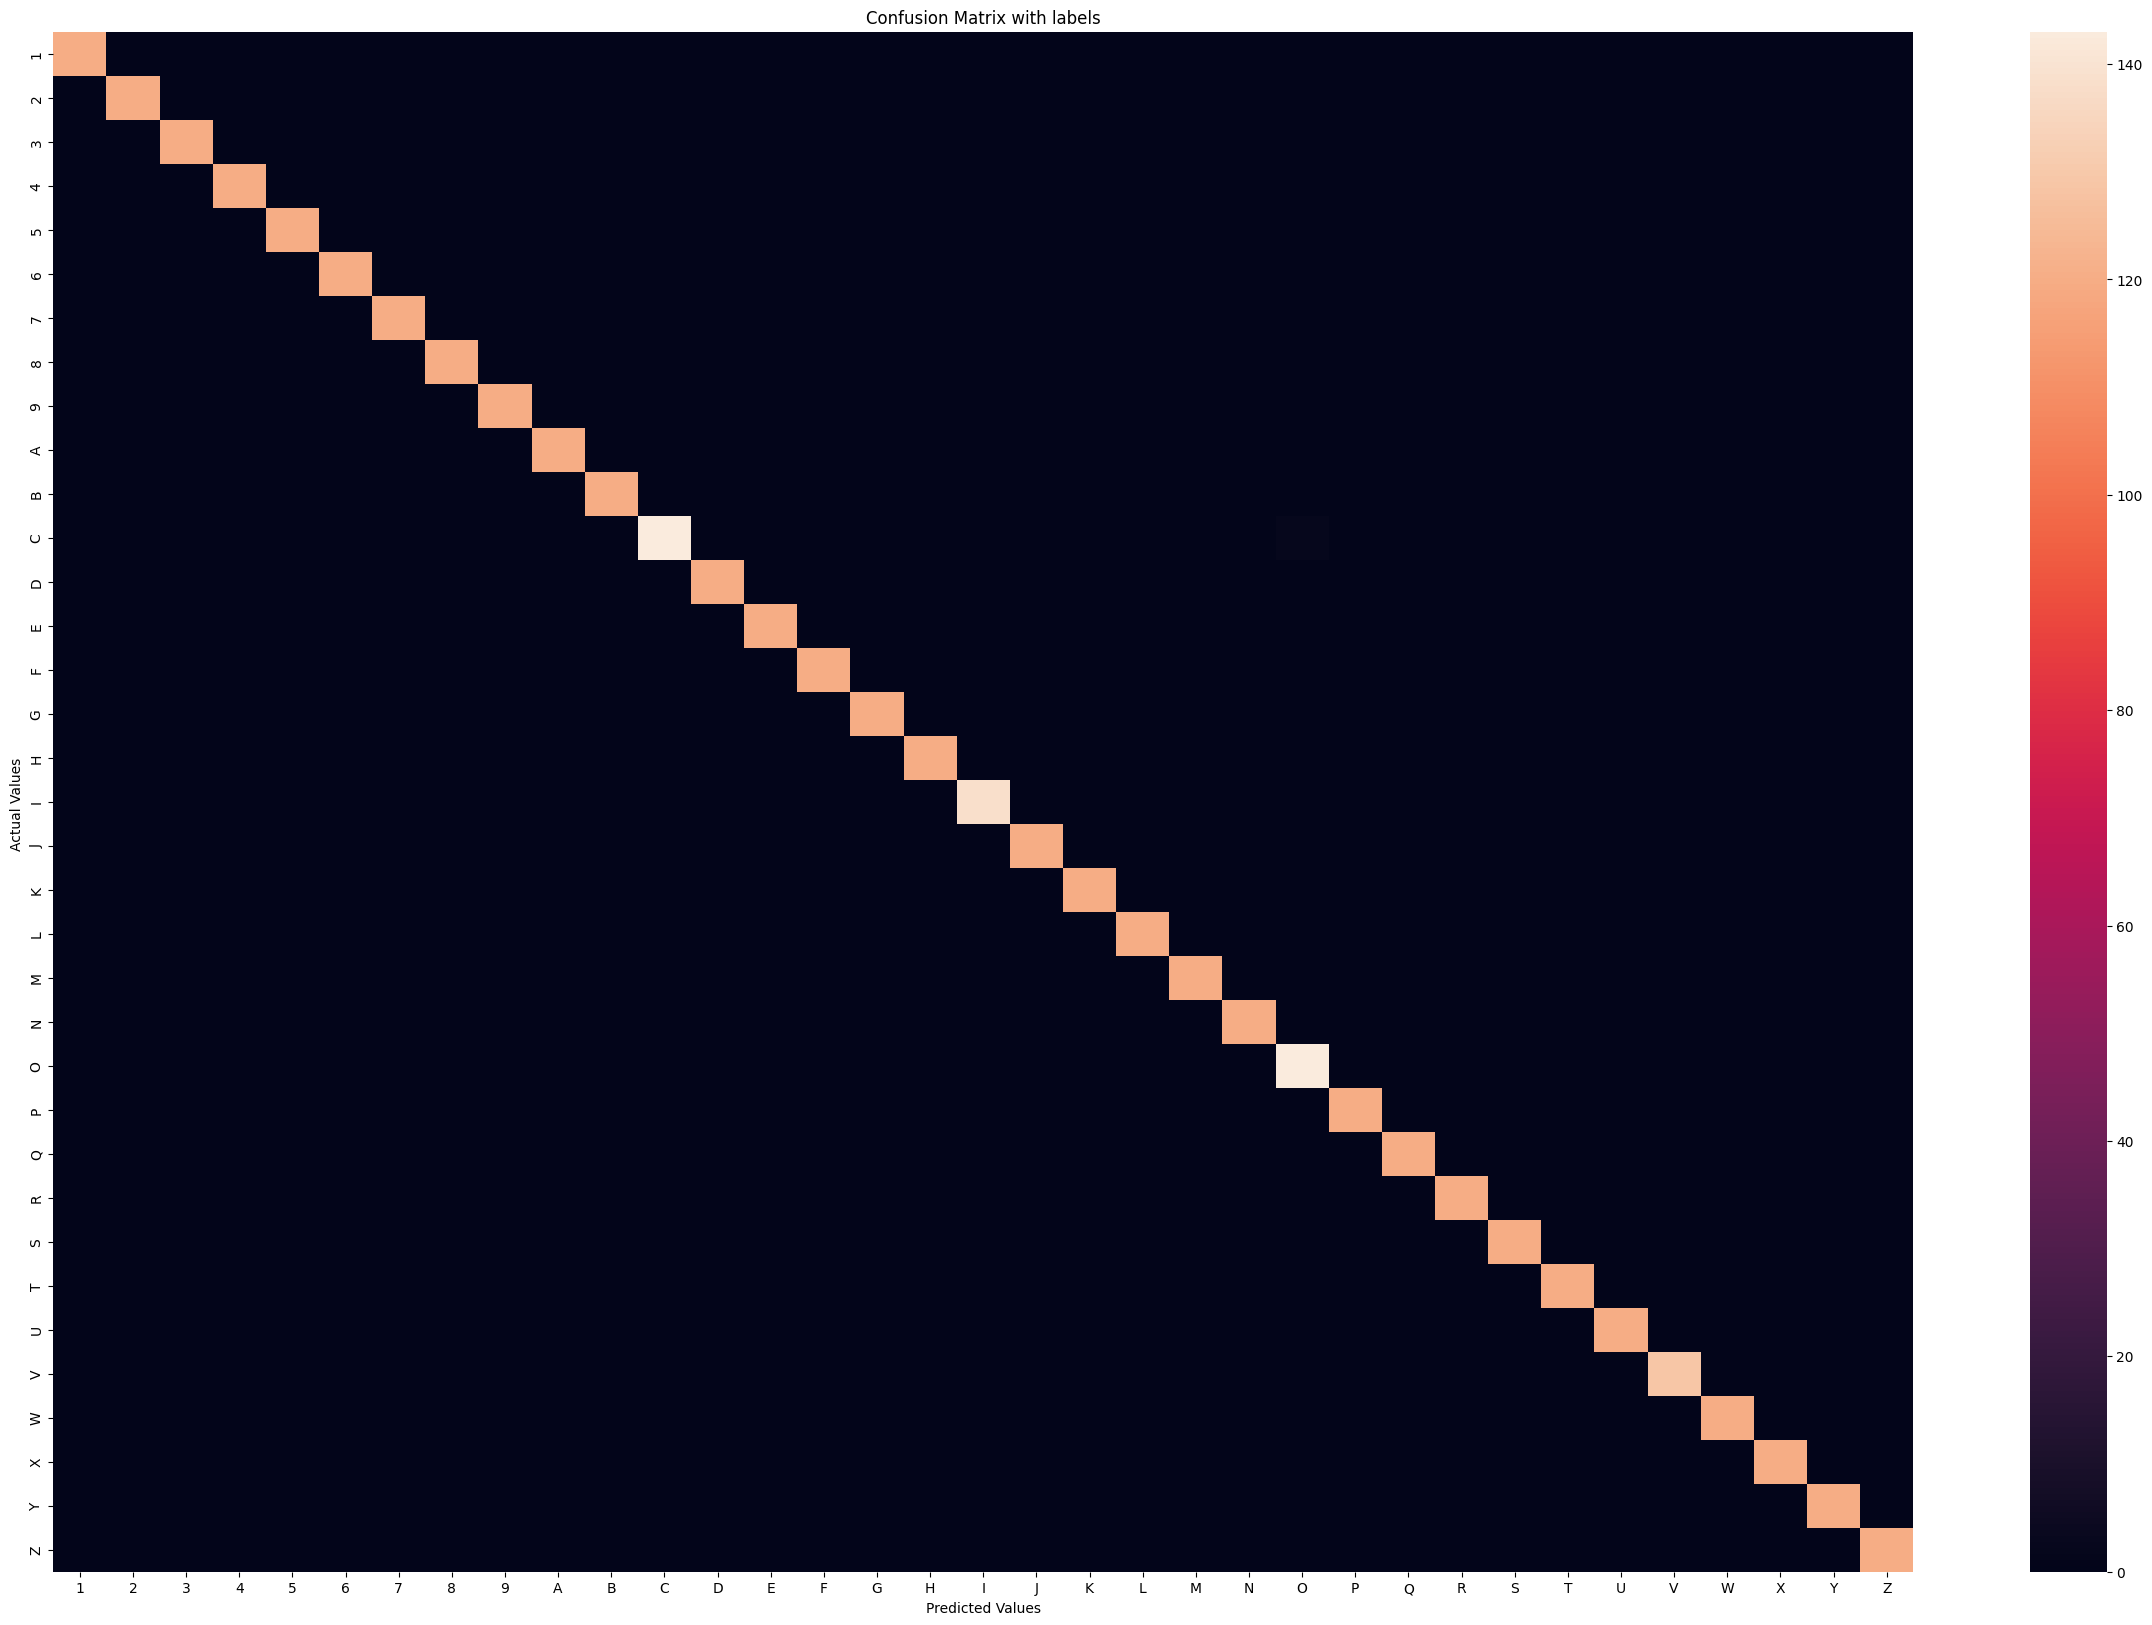

In [16]:
plt.figure(figsize=(30, 20))

ax = sns.heatmap(metrics.confusion_matrix(true_classes,predicted_classes))
ax.set_title('Confusion Matrix with labels')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ')


## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(class_labels)
ax.yaxis.set_ticklabels(class_labels)

plt.show()

In [17]:
model.save('ISLResNet50V2.h5')

In [18]:
from keras.models import model_from_json
json_model = model.to_json()

with open('ISLResNet50V2.json', 'w') as json_file:
    json_file.write(json_model)

In [19]:
confusion = metrics.confusion_matrix(true_classes, predicted_classes)
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[120   0   0 ...   0   0   0]
 [  0 120   0 ...   0   0   0]
 [  0   0 120 ...   0   0   0]
 ...
 [  0   0   0 ... 120   0   0]
 [  0   0   0 ...   0 120   0]
 [  0   0   0 ...   0   0 120]]


<Axes: >

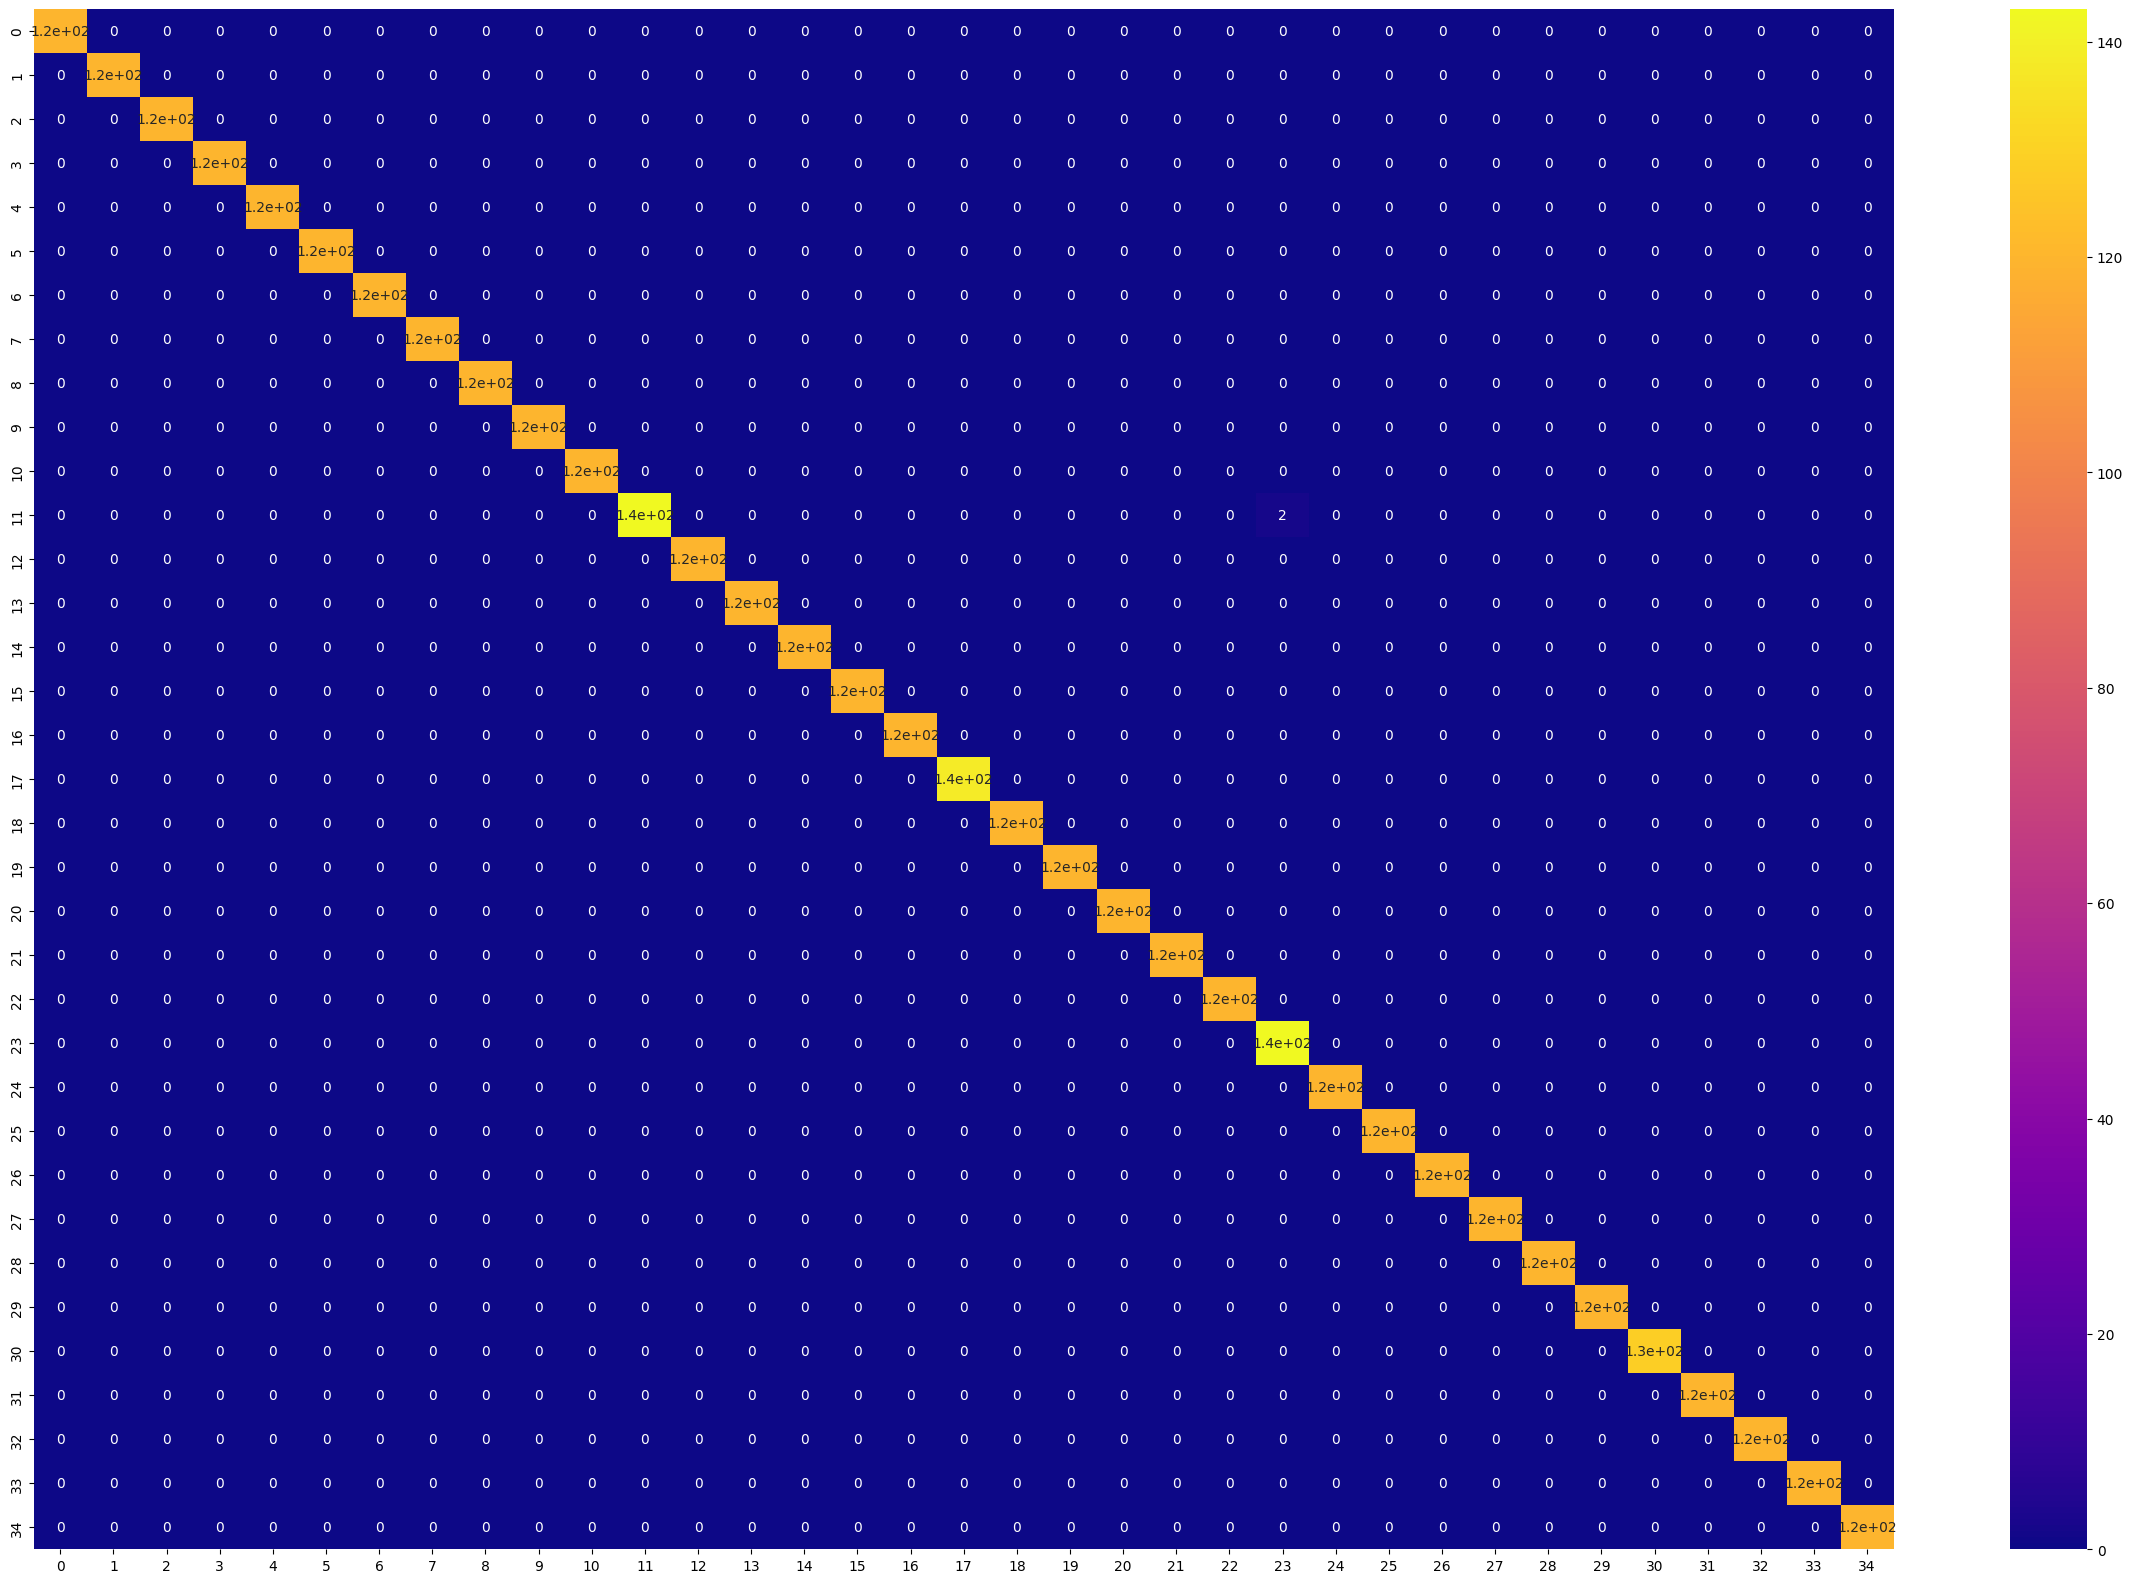

In [20]:
plt.figure(figsize=(30, 20))
sns.heatmap(confusion, cmap="plasma", annot=True)